# Exploring the Allen Cell Types Database

In this notebook, we'll explore data from the [allen cell types database](http://celltypes.brain-map.org/). These databases include electrophysiological, morphological, and transcriptomic data from both mouse and humans!

To interact with these data, the allen institute provides a [SDK](http://alleninstitute.github.io/AllenSDK/cell_types.html). This notebook loosely follows some of the code samples [here](http://alleninstitute.github.io/AllenSDK/_static/examples/nb/cell_types.html) to import the data.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1) Get the cells!

In [2]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path (like this), it will go
# into your current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# get all the cells
cells = ctc.get_cells()

2) Preprocess cells

In [3]:
filter_frame = lambda frame, str : frame.drop(list(frame.filter(regex = str)), axis = 1)
# get ephys features for recorded cells
ephys_features = ctc.get_ephys_features(dataframe=True)
ef_df = ephys_features.drop(['has_delay'], axis=1)
ef_df.set_index('specimen_id', inplace=True)
ef_df = filter_frame(ef_df, 'id')
ef_df.head()
# get morphology features for reconstructed cells
morphology_features = ctc.get_morphology_features(dataframe=True)
mf_df = morphology_features.drop(
    ['average_bifurcation_angle_remote', 'hausdorff_dimension'], axis=1)
mf_df = filter_frame(mf_df, 'scale_factor')
mf_df.set_index('specimen_id', inplace=True)
mf_df = filter_frame(mf_df, 'id')
# or download both morphology and ephys features at the same time
# all_features = ctc.get_all_features(dataframe=True, require_reconstruction=True)

/usr/local/lib/python2.7/site-packages/allensdk/core/cell_types_cache.py:154: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  features_df = pd.DataFrame.from_csv(file_name)
/usr/local/lib/python2.7/site-packages/allensdk/core/cell_types_cache.py:188: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  features_df = pd.DataFrame.from_csv(file_name)


3) Extract general properties that we might want to try to predict for each cell

In [4]:
# find matches
# ids = [c['id'] for c in cells]
cell_index = { c['id']: c for c in cells }
ids = cell_index.keys()
in_both = list(set(ids).intersection(set(ef_df.index)))
# get info about each cell
cell_type = list()
for cid in in_both:
    this_cell = cell_index[cid]
    this_donor = this_cell['donor']
    cell_type.append((this_cell['dendrite_type'],
                     this_cell['structure']['acronym'],
                     this_donor['sex_full_name'],
                     this_donor['age_id'],
                     this_cell['transgenic_line']))
# convert to dataframe
ct_df = pd.DataFrame(columns=['spines','structure', 'sex', 'age_id', 'transgenic_line'],
                     data=cell_type, index=in_both)
ct_df.head()

,spines,structure,sex,age_id,transgenic_line
480116737,spiny,VISp5,Male,20,Rorb-IRES2-Cre
318543876,aspiny,VISp4,Male,298414240,Pvalb-IRES-Cre
471767045,spiny,VISp5,Male,298414240,Rbp4-Cre_KL100
485287944,spiny,VISp6a,Female,97,Ntsr1-Cre_GN220
481099785,aspiny,VISp4,Male,20,Htr3a-Cre_NO152


In [35]:
# make sure both have same index
X = ef_df.loc[in_both, :]
Y = ct_df.loc[in_both,:]
threshold = 50
vc = Y.structure.value_counts()

structures_to_keep = vc[vc >= threshold].index.values
sc = Y.spines.value_counts()
spines_to_keep = sc[sc >= threshold].index.values
to_keep = Y['structure'].isin(structures_to_keep) & Y['spines'].isin(spines_to_keep)
Y = Y.loc[to_keep, :]
X = X.loc[to_keep, :]

4) Examine the electrophysiological features 

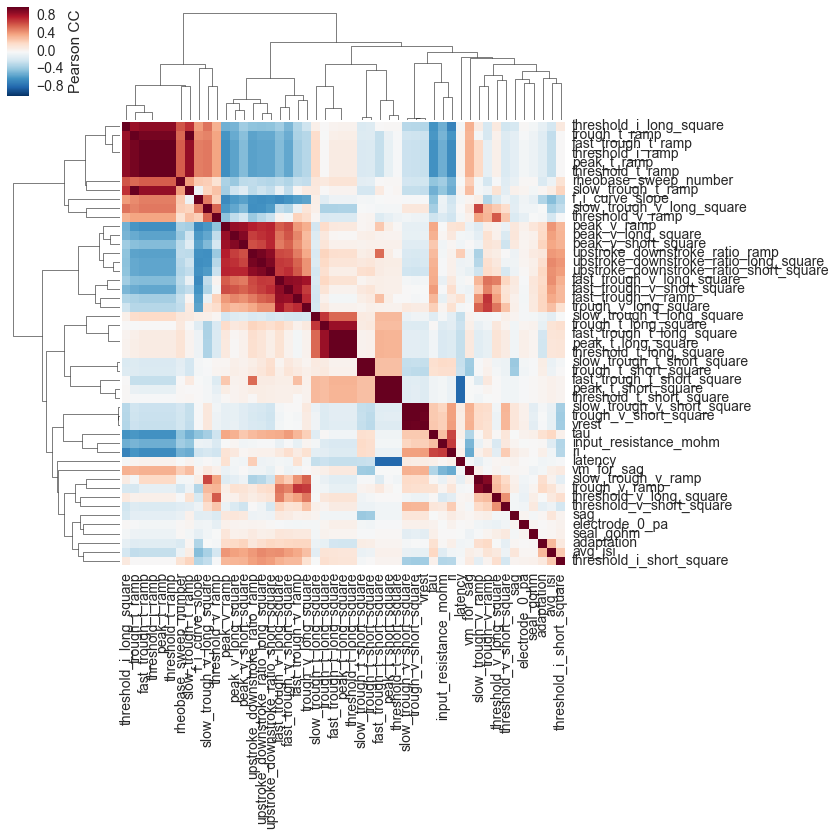

In [36]:
sns.set(font_scale=1.4)
g = sns.clustermap(X.corr(), cbar_kws={'label': 'Pearson CC'})
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0);

## How well can we predict whether a neuron is spiny or not?

For this classification problem, we'll start by using logistic regression.

In [37]:
# remove cells with lots of NaNs
bad_cells = pd.isna(X[['fast_trough_t_ramp',
                       'electrode_0_pa',
                       'slow_trough_t_short_square']]).any(axis=1)
Y = Y.loc[~bad_cells]
X = X.loc[~bad_cells, :]
# remove categories with lots of NaNs
X.drop(X.columns[np.sum(pd.isna(X)) > 50], axis=1, inplace=True)

In [38]:
# scale all features
from sklearn.preprocessing import RobustScaler
X_scaled = RobustScaler().fit_transform(X)

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
n_folds = 5
coef_mat = np.zeros((n_folds, X_scaled.shape[1]))
skf = StratifiedKFold(n_splits=5)
logistic_model = LogisticRegression(random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(X_scaled, Y.spines)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = Y.spines.iloc[train_index], Y.spines.iloc[test_index]
    logistic_model.fit(X_train, y_train)
    coef_mat[i,:] = logistic_model.coef_
    print(accuracy_score(y_test, logistic_model.predict(X_test)))

0.959537572254
0.953757225434
0.96511627907
0.953216374269
0.982456140351


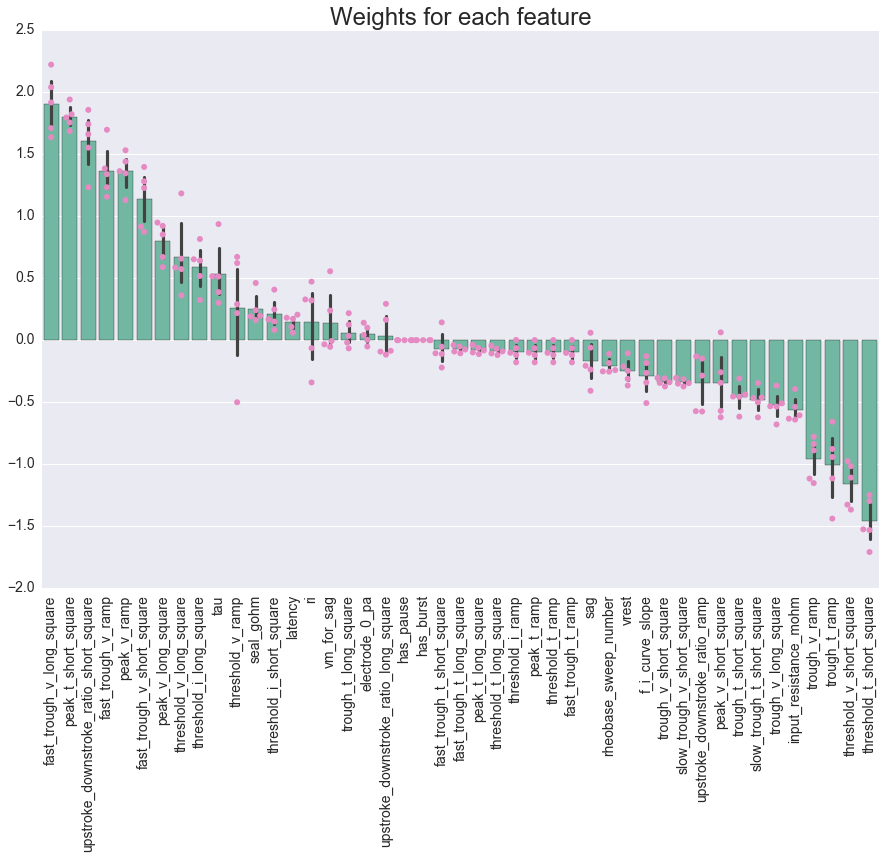

In [100]:
# examine the weights
network_pal = sns.color_palette("Set2", 5)
coefs = pd.DataFrame(coef_mat)
coefs.columns = X.columns
coefs = coefs.reindex(columns=coefs.mean().sort_values(ascending=False).index)
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(data=coefs, color=network_pal[0], ax=ax);
sns.swarmplot(data=coefs, color=network_pal[3], ax=ax, size=6);
plt.title('Weights for each feature', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

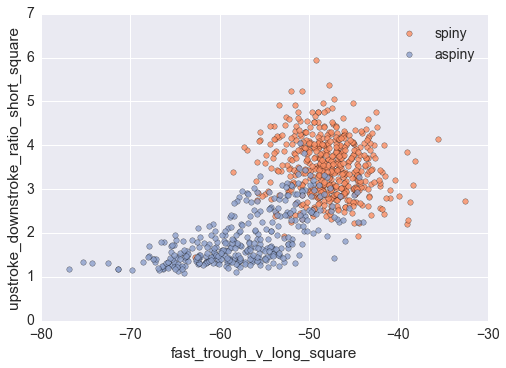

In [135]:
# view separation from top features
for i, spine_type in enumerate(Y.spines.unique()):
    is_type = Y.spines == spine_type
    plt.scatter(X.fast_trough_v_long_square[is_type],
                X.upstroke_downstroke_ratio_short_square[is_type],
                c = network_pal[i+1],
                label=spine_type,
                s=30, alpha=0.8)
plt.xlabel('fast_trough_v_long_square')
plt.ylabel('upstroke_downstroke_ratio_short_square')
plt.legend();

In [90]:
# Alternatively, if you're only intersted in the scores this can be done at once
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logistic_model, X_scaled, Y.spines, cv=skf)
print(scores)
print('Mean score = %.4f' % (scores.mean()))

[ 0.95953757  0.95375723  0.96511628  0.95321637  0.98245614]
Mean score = 0.9628


### See if hyperparameter optimization improves our predictions
As seen in the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) for logistic regression, the main parameter we can adjust is the strength of the regularization parameter, `C`.

In this example, we also use the pipeline operation, which allows us to jointly test optimizing reducing the number of datapoints in our model, as well as the parameters we wish to tune for logistic regression.

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# hold out test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.spines,
                                                    train_size=0.75, test_size=0.25)

pipe = Pipeline(steps=[('pca', PCA()), ('logistic', logistic_model)])
params = {'logistic__penalty': ['l1', 'l2'],
          'logistic__C': np.logspace(-4, 2, 40),
         'pca__n_components': np.arange(5, X_scaled.shape[1]+1, 10)}
estimator = GridSearchCV(pipe, params, cv=3, verbose=1, scoring='accuracy')
estimator.fit(X_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   22.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic__C': array([  1.00000e-04,   1.42510e-04,   2.03092e-04,   2.89427e-04,
         4.12463e-04,   5.87802e-04,   8.37678e-04,   1.19378e-03,
         1.70125e-03,   2.42446e-03,   3.45511e-03,   4.92388e-03,
         7.01704e-03,   1.00000e-02,   1.42510e-02,   2.03092e-02,
     ... 1.00000e+02]), 'pca__n_components': array([ 5, 15, 25, 35, 45]), 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True,

In [95]:
print(estimator.best_estimator_)
print('Test score = %.4f' % accuracy_score(y_test, estimator.predict(X_test)))

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=8.3767764006829246, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
Test score = 0.9814


### Wrapping model in helper class for convenience

In [474]:
class SklearnHelper(object):
    def __init__(self, clf, scorer, seed=42, params={}):
        if 'random_state' in clf().get_params().keys():
            params['random_state'] = seed
        elif 'random_state' in params.keys():
            params.pop('random_state')
        self.clf = clf(**params)
        self.scorer = scorer

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x_test):
        return self.clf.predict(x_test)
    
    def score(self, x_test, y_true):
        return self.scorer(y_true, self.predict(x_test))
    
    def score_cv(self, x, y):
        return cross_val_score(self.clf, x, y, cv=skf)

In [475]:
# additional examples with a SVM
from sklearn.svm import LinearSVC
svm_model = SklearnHelper(LinearSVC, accuracy_score)
svm_scores = svm_model.score_cv(X_scaled, Y.spines)
print(svm_scores)
print('Mean score for default SVM = %.4f' % (svm_scores.mean()))

[ 0.96531792  0.97109827  0.96511628  0.93567251  0.98830409]
Mean score for default SVM = 0.9651


### Alternate problems for the reader:
* Did the grid search find the best logistic regression model? If not, how would you improve it?
* How well can one predict structure, sex, or transgenic line?
* Where does the model fail and why? What alternate features would help?
* How does the performance of logistic regression compare to other models? 

## Examine both ephys and morphological features

In [138]:
# combine ephys and morphology dataframe
# add prefix to column names so we can later subset columns
mf_and_ef = pd.concat([ef_df.add_prefix("ef."), mf_df.add_prefix("mf.")], axis=1, join="inner")
corrmat = mf_and_ef.corr()
# make a list of colors for each feature
cls = list()
for clm in corrmat.columns:
    if clm.split(".")[0] == "ef":
        cls.append(network_pal[0])
    else:
        cls.append(network_pal[1])

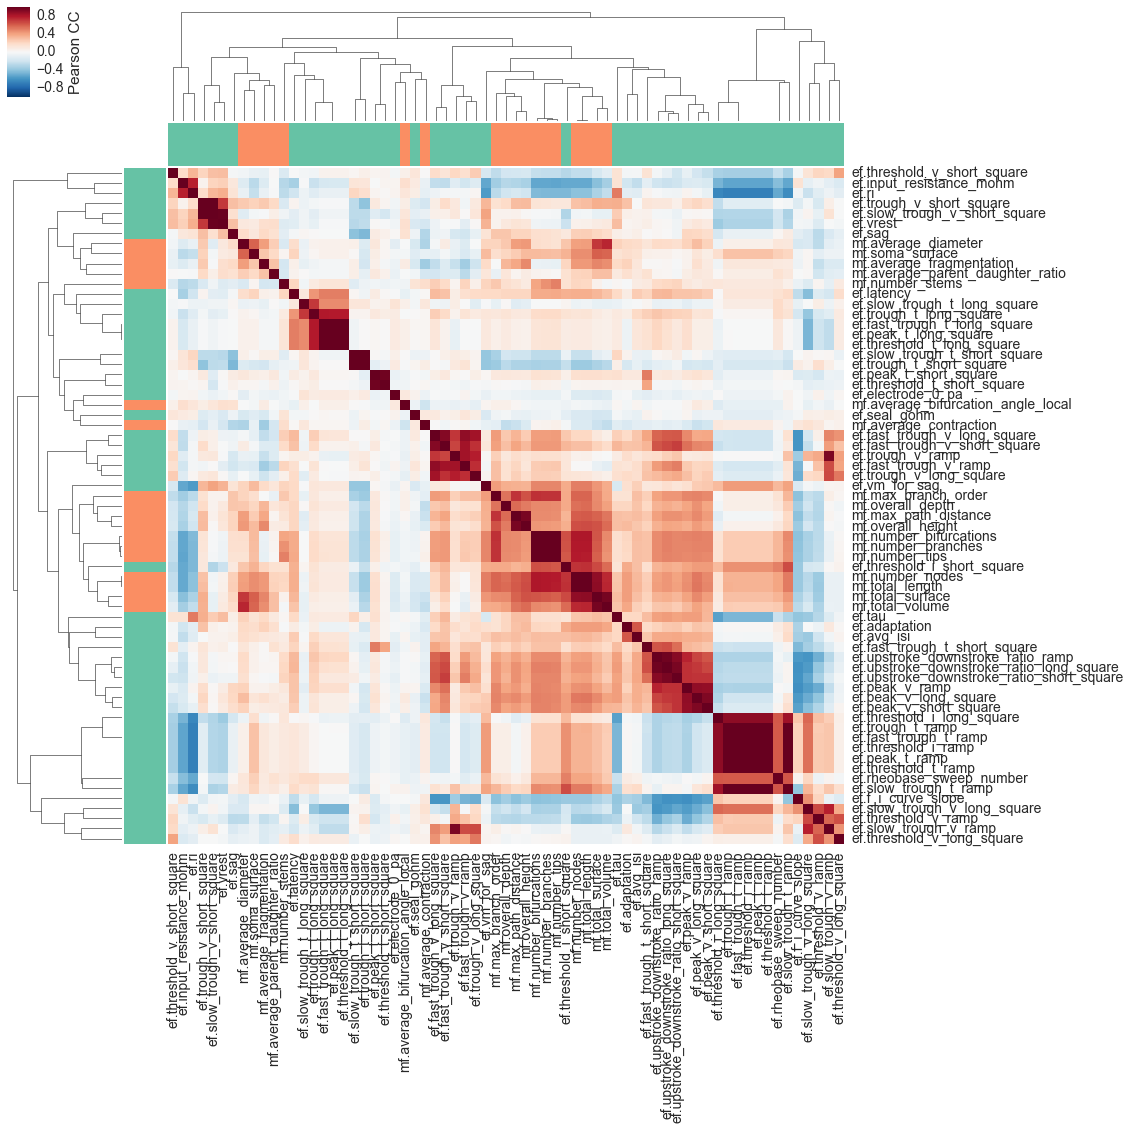

In [139]:
sns.set(font_scale=1.4)
g = sns.clustermap(corrmat, row_colors=cls, col_colors=cls,
                   cbar_kws={'label': 'Pearson CC'}, figsize=(15,15))
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0);

## A regression problem: Can we predict physiological properties from the structure?

In [507]:
from sklearn.preprocessing import Imputer
feature = 'mf.total_length'
y_mf = mf_and_ef[feature]
X_ef = filter_frame(mf_and_ef, 'mf.') # convert strings
X_ef.drop(X_ef.columns[np.sum(pd.isna(X_ef)) > 50], axis=1, inplace=True)
bad_cells = np.sum(pd.isna(X_ef), axis=1) > 5
X_ef = X_ef.loc[~bad_cells]
y_mf = y_mf.loc[~bad_cells]
X_ef_imputed = Imputer().fit_transform(X_ef)
X_ef_scaled = RobustScaler().fit_transform(X_ef_imputed)
X_ef.head()

,ef.avg_isi,ef.electrode_0_pa,ef.f_i_curve_slope,ef.fast_trough_t_long_square,ef.fast_trough_t_ramp,ef.fast_trough_t_short_square,ef.fast_trough_v_long_square,ef.fast_trough_v_ramp,ef.fast_trough_v_short_square,ef.has_burst,...,ef.trough_t_ramp,ef.trough_t_short_square,ef.trough_v_long_square,ef.trough_v_ramp,ef.trough_v_short_square,ef.upstroke_downstroke_ratio_long_square,ef.upstroke_downstroke_ratio_ramp,ef.upstroke_downstroke_ratio_short_square,ef.vm_for_sag,ef.vrest
specimen_id,,,,,,,,,,,,,,,,,,,,,
485466109,118.397143,-90.575616,0.307589,1.06977,7.203945,1.024593,-45.968754,-49.093754,-53.800002,False,...,7.204045,1.233473,-46.156254,-49.218753,-66.318753,2.026000,1.827572,1.818158,-82.406250,-65.503044
479013100,91.322222,-46.761876,0.223864,1.19024,3.826338,1.025363,-44.937504,-43.635419,-47.395833,False,...,3.862007,1.806510,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374
569095789,112.245000,3.015000,0.150000,1.10920,5.458287,1.025020,-51.062504,-57.916670,-56.531254,False,...,5.483953,1.225900,-51.406254,-59.552087,-81.875008,2.199872,2.220031,2.235442,-95.843758,-81.065971
478888083,59.215625,10.571250,0.397263,1.23072,4.531655,1.024268,-54.718750,-54.687503,-59.166670,False,...,4.531717,1.323212,-55.062504,-54.781253,-71.250003,1.473594,1.444992,1.653886,-94.312508,-70.492218
508279351,8.650000,15.299999,0.032146,1.17316,14.217820,1.025187,-49.750004,-52.687503,-50.135419,False,...,14.217933,1.025203,-49.812504,-52.802086,-50.171877,2.507462,2.517398,2.635798,-88.562500,-80.505516


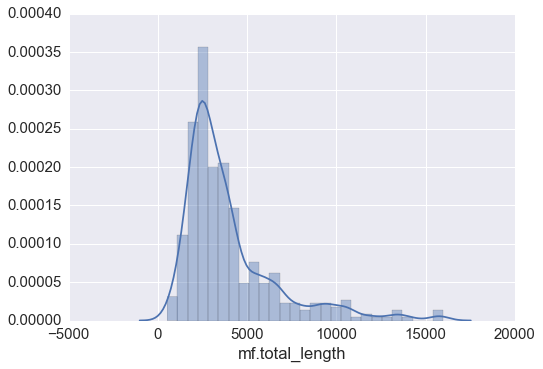

In [508]:
sns.distplot(y_mf);

### Try Lasso and Ridge Regression

In [509]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X_ef_scaled, y_mf,
                                                    train_size=0.7, test_size=0.3,
                                                    random_state=0)
alphas = np.logspace(-8, 2, 200)
lasso_model = SklearnHelper(LassoCV, mean_squared_error, params={'alphas':alphas})
lasso_model.train(X_train, y_train)
param_dict = {'alphas': alphas, 'store_cv_values': True}
ridge_model = SklearnHelper(RidgeCV, mean_squared_error, params=param_dict)
ridge_model.train(X_train, y_train)

In [510]:
# Check that the coefficients are sparse for Lasso (L1)
print(lasso_model.clf.coef_)
# Check that the coefficients are small for ridge (L2)
print(ridge_model.clf.coef_)

[ -0.00000000e+00  -6.62151741e+01   5.29610137e+01  -2.21729044e+02
   5.56130839e+02  -2.27322649e+02  -0.00000000e+00  -1.00465076e+03
  -8.01436123e+01   0.00000000e+00   0.00000000e+00  -3.31630690e+02
   1.41862633e+02  -0.00000000e+00   4.07757266e-01   1.03571866e+03
   4.09928914e+02  -0.00000000e+00  -1.84362943e+02   2.18366331e+02
  -8.14459268e+02   2.84015676e+02  -6.70263444e-01   8.07205927e+02
  -4.83224707e+02   2.42944089e+00   7.55978001e+02  -0.00000000e+00
   1.13358837e+01  -5.24318763e+02  -0.00000000e+00  -4.74904613e+02
   3.74752975e+01  -0.00000000e+00   1.09640329e+02  -2.25603871e+02
   3.20213033e+02   3.85778809e+02  -1.45622907e+02   6.88992111e+02
   0.00000000e+00  -0.00000000e+00   2.70845020e+02   3.53507329e+02]
[  -19.66930458   -62.37410961    83.48968763  -788.05277178  -152.11660915
  -523.7195332     14.40557664  -976.27438486  -482.36594026     0.             0.
  -348.9033427    131.3098342    302.50101073   -82.31689218  1446.36184069
   64

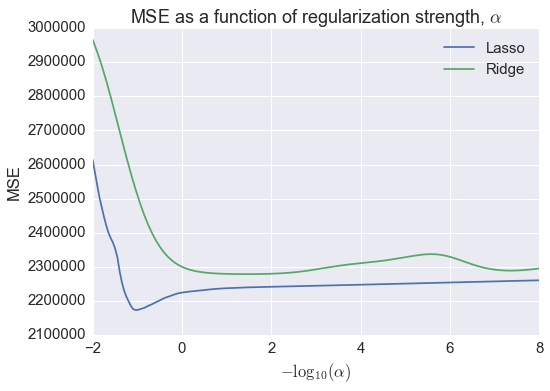

In [511]:
# view the regularization path
sns.set(font_scale=1.5, palette="deep")
plt.plot(-np.log10(lasso_model.clf.alphas_), np.mean(lasso_model.clf.mse_path_, axis=1), label='Lasso');
plt.plot(-np.log10(alphas), np.mean(ridge_model.clf.cv_values_, axis=0), label='Ridge');
plt.ylabel('MSE')
plt.xlabel(r'$-\log_{10}(\alpha)$')
plt.legend()
plt.title(r'MSE as a function of regularization strength, $\alpha$');

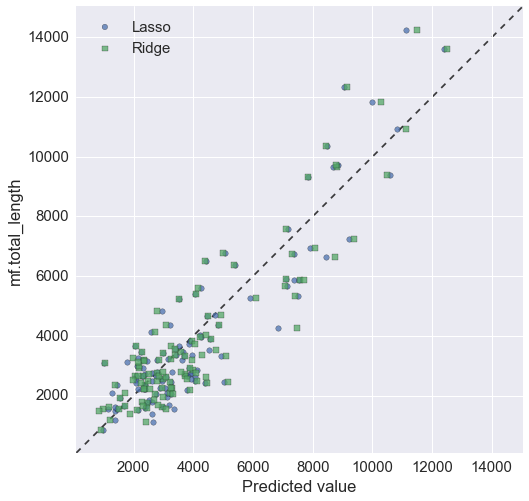

In [523]:
cls = sns.color_palette("deep", 5)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
fig,ax = plt.subplots(figsize=(8,8))
plt.scatter(y_pred_lasso, y_test, c = cls[0], s=30, alpha=0.75, label='Lasso')
plt.scatter(y_pred_ridge, y_test, c = cls[1], marker='s', s=30, alpha=0.75, label='Ridge')
plt.axis('tight')
plt.legend(loc=2)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
plt.axis('equal')
plt.xlabel('Predicted value')
plt.ylabel(feature)
ax.set_xlim(lims)
ax.set_ylim(lims);

### Alternate questions for the reader:
* How does elastic net look?
* How do non-linear models compare?
* Where do the models fail and why? What alternate features would help?
* How well can you predict ephys features from the morphological ones?

In [ ]:
# example of how to use TPOT
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.75, test_size=0.25)

In [ ]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=10)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

In [ ]:
tpot.fitted_pipeline_